# Mews Hotel Data Task Report

## Objective: 
- Provide solutions for three data questions

## Structure
- Feature Engineering
- Question One
- Question Two
- Question Three


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import quantile
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,mean_squared_error,make_scorer,accuracy_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [3]:
## Load, read and merge the datasets 
path=os.path.join(os.getcwd(),'data')
reservations=pd.read_csv(os.path.join(path,'reservations.csv'))
rates=pd.read_csv(os.path.join(path,'rates.csv'))
df=reservations.merge(rates, left_on='RateId',right_on='RateId',how='left')
df.drop(['SettlementType_x'],axis=1,inplace=True)
df.rename(columns={'SettlementType_y':'SettlementType'},inplace=True)

# Feature Engineering

In [4]:
# Missing values
total_missing=df.isnull().sum().sort_values(ascending=False)
percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing=pd.concat([total_missing,percent],keys=['total_missing','percent'],axis=1).head(5)
print(missing)
# Remove fetures with % of missing values more than the threshold 70%, hence remove CancellationReason 
df=df.drop(missing[missing.percent>0.7].index,1)

# Quartile cut continuous numerical features into bands and turn them to ordinal NightCost_Sum, AgeGroup,GuestCount_Sum
# AgeGroup:   [[0,25) < [25,35) < [35,45) < [45, 55) < [55,65) < [65,100] ]
df.loc[(df.AgeGroup==0),'AgeGroup']=0
df.loc[(df.AgeGroup==25),'AgeGroup']=1
df.loc[(df.AgeGroup==35),'AgeGroup']=2
df.loc[(df.AgeGroup==45),'AgeGroup']=3
df.loc[(df.AgeGroup==55),'AgeGroup'] =4
df.loc[(df.AgeGroup>=65),'AgeGroup'] =5
# GuestCount_Sum: [(0.999, 2.0] < (2.0, 4.0] < (4.0, 6.0] < (6.0, 26.0]], specifically guest of 2:500 guest of 1:258
guest_band=pd.qcut(df.GuestCount_Sum,4)
df.loc[(df.GuestCount_Sum>0.999) & (df.GuestCount_Sum<=2.0),'GuestCount_Sum']=0
df.loc[(df.GuestCount_Sum>2.0)&(df.GuestCount_Sum<=4.0),'GuestCount_Sum']=1
df.loc[(df.GuestCount_Sum>4.0)&(df.GuestCount_Sum<=6.0),'GuestCount_Sum']=2
df.loc[(df.GuestCount_Sum>6.0)&(df.GuestCount_Sum<=26.0),'GuestCount_Sum']=3

# NightCost_Sum: [(-0.001, 273.11] < (273.11, 544.629] < (544.629, 2858.34]]
cost_band=pd.qcut(df.NightCost_Sum,3)
df.loc[(df.NightCost_Sum>-0.001) & (df.NightCost_Sum<=273.11),'NightCost_Sum']=0
df.loc[(df.NightCost_Sum>273.11) & (df.NightCost_Sum<=544.629),'NightCost_Sum']=1
df.loc[(df.NightCost_Sum>544.629) & (df.NightCost_Sum<=2858.34),'NightCost_Sum']=2

# FILLNA
# Fillna for CommanderOrigin,TravelAgency,NationalityCode
# CommanderOrigin is most positively correlated to ReservationState(0.44) & NightCost_Sum(0.37),hence we will fillna by the combination of those two
guess_origin=np.zeros((5,3))
for i in range(0,5):
    for j in range(0,3):
        guess_df=df[(df.ReservationState==i+1)&(df.NightCost_Sum==j)]['CommanderOrigin'].dropna()
        median=guess_df.median()
        guess_origin[i,j]=median
    
    for i in range(0,5):
        for j in range(0,3):
            df.loc[(df.CommanderOrigin.isnull())&(df.ReservationState==i+1)&(df.NightCost_Sum==j),'CommanderOrigin']=guess_origin[i,j]
# # Fillna for TravelAgency using the combination of AgeGroup and BusinessSegment:
le=LabelEncoder()
df['BusinessSegment']=le.fit_transform(df.BusinessSegment)
business_segment=dict(zip(le.classes_,le.transform(le.classes_)))
df.loc[(df.AgeGroup==0)&(df.BusinessSegment==2),'TravelAgency']=df.loc[(df.AgeGroup==0)&(df.BusinessSegment==2),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==2)&(df.BusinessSegment==2),'TravelAgency']=df.loc[(df.AgeGroup==2)&(df.BusinessSegment==2),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==3)&(df.BusinessSegment==1),'TravelAgency']=df.loc[(df.AgeGroup==3)&(df.BusinessSegment==1),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==3)&(df.BusinessSegment==2),'TravelAgency']=df.loc[(df.AgeGroup==3)&(df.BusinessSegment==2),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==3)&(df.BusinessSegment==3),'TravelAgency']=df.loc[(df.AgeGroup==3)&(df.BusinessSegment==3),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==4)&(df.BusinessSegment==1),'TravelAgency']=df.loc[(df.AgeGroup==4)&(df.BusinessSegment==1),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==4)&(df.BusinessSegment==2),'TravelAgency']=df.loc[(df.AgeGroup==4)&(df.BusinessSegment==2),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==5)&(df.BusinessSegment==1),'TravelAgency']=df.loc[(df.AgeGroup==5)&(df.BusinessSegment==1),'TravelAgency'].fillna('Unknown')
df.loc[(df.AgeGroup==5)&(df.BusinessSegment==2),'TravelAgency']=df.loc[(df.AgeGroup==5)&(df.BusinessSegment==2),'TravelAgency'].fillna('Unknown')
guess_agency=np.zeros((6,6),dtype=object)
for i in range(0,6):
    for j in range(0,6):
        mode=df[(df.AgeGroup==i)&(df.BusinessSegment==j)]['TravelAgency'].dropna().mode()[0]
        guess_agency[i,j]=mode
    
    for i in range(0,6):
        for j in range(0,6):
            df.loc[(df.TravelAgency.isnull())&(df.AgeGroup==i)&(df.BusinessSegment==j),'TravelAgency']=guess_agency[i,j]
## Fillna for NationalityCode using the combination of AgeGroup and GuestCount_Sum:
guess_nation=np.zeros((6,4),dtype=object)
for i in range(0,6):
    for j in range(0,4):
        mode=df[(df.AgeGroup==i)&(df.GuestCount_Sum==j)]['NationalityCode'].dropna().mode()[0]
        guess_nation[i,j]=mode
    
    for i in range(0,6):
        for j in range(0,4):
            df.loc[(df.NationalityCode.isnull())&(df.AgeGroup==i)&(df.GuestCount_Sum==j),'NationalityCode']=guess_nation[i,j]
        

# Convert Dtype, create new feature
df['StartUtc']=df.StartUtc.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
df['EndUtc']=df.EndUtc.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
df['CreatedUtc']=df.CreatedUtc.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
df['StartWeekDay']=df.StartUtc.apply(lambda x: pd.Timestamp(x).day_name())
df['EndWeekDay']=df.EndUtc.apply(lambda x: pd.Timestamp(x).day_name())
df['StartWCode']=df.StartUtc.apply(lambda x: pd.Timestamp(x).weekday())
df['EndWCode']=df.EndUtc.apply(lambda x:pd.Timestamp(x).weekday())
# Split features into cat_features and numerical features
cat_features=df.select_dtypes(include=['object']).columns
num_features=df.select_dtypes(exclude=['object']).columns
num_features=num_features.drop(['EnterpriseTimeZone','Tier','SettlementAction','SettlementTrigger','SettlementValue','SettlementType'])

                    total_missing   percent
CancellationReason           1806  0.722111
CommanderOrigin              1374  0.549380
TravelAgency                 1259  0.503399
NationalityCode              1096  0.438225
SettlementType                  0  0.000000


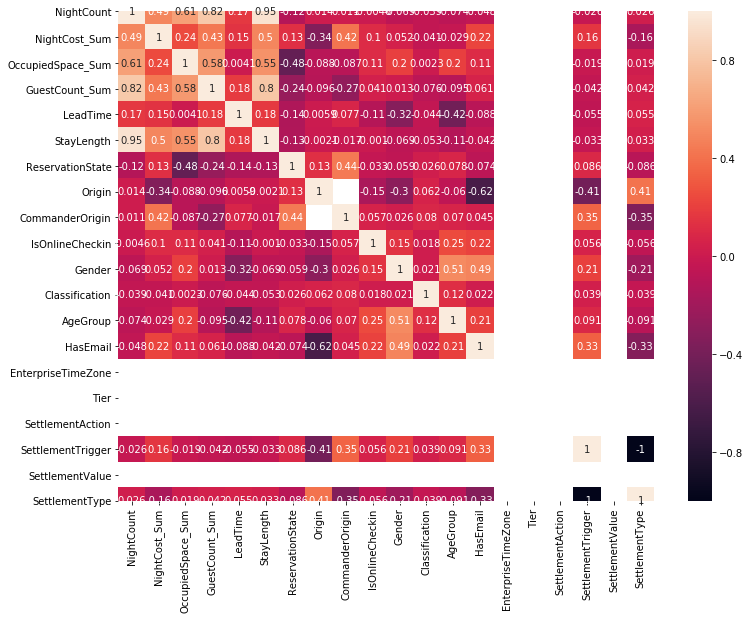

In [5]:
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(),annot=True)

# Questions

## What are the popular choices of booking rates for different segment of customers

### RandomForestClassifier

In [5]:
## Label encode and combine features to create base input for customer segmentation
df_new=df.copy()
df_new['Gender']=df_new.Gender.apply(lambda x: x+1)
df_new['AgeGroup']=df_new.AgeGroup.apply(lambda x: x+1)
df_new['AgeGender']=(df_new.AgeGroup*df_new.Gender)
df_new['NationalityCode']=le.fit_transform(df_new.NationalityCode.astype('str'))
le1=LabelEncoder()
df_new['ShortRateName']=le1.fit_transform(df_new.ShortRateName)
nation=dict(zip(le.classes_,le.transform(le.classes_)))
## Create training, test data
train=df_new[['AgeGroup','Gender','NationalityCode','AgeGender']]
y=df_new.ShortRateName.values
X_train,X_test,y_train,y_test=train_test_split(train,y,test_size=0.3,random_state=0)
acc_score= make_scorer(accuracy_score)

In [7]:
## Modelling, use RandomForestClassifier to classify current customer base 
rf=RandomForestClassifier()
params={'criterion':['gini','entropy'],
 'max_depth':[3,5],
  'max_features':['auto','sqrt','log2'],
   'min_samples_split':[2,3],
    'n_estimators':[100,500] }
clf=GridSearchCV(rf,params,scoring=acc_score)
clf.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [ ]:
# Use RandomForestClassifier to classify current customer base based on RateName 
# and tune hyperparameters using GridSearchCV
clf.best_params_
clf.refit
y_pred=clf.predict(X_test)

In [313]:
## Use KFold to validate the model with Mean Accuray:0.5573482071713147 
def run_kfold(clf):
    kf=KFold(n_splits=10)
    fold=0
    outcome=[]
    for train_index,test_index in kf.split(train):
        fold+=1
        X_train,X_test= train.values[train_index],train.values[test_index]
        y_train,y_test = y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        accuracy=accuracy_score(y_test,y_pred)
        outcome.append(accuracy)
        print('Fold{} accuracy:{}'.format(fold,accuracy))
    mean_outcome = np.mean(outcome)
    print('Mean Accuray:{}'.format(mean_outcome))

In [314]:
## According to KFoldCV, the Mean Accuray is 0.5573482071713147 and the model performed well across 10 folds. 
run_kfold(clf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold1 accuracy:0.6294820717131474


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold2 accuracy:0.736


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold3 accuracy:0.812


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold4 accuracy:0.612


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold5 accuracy:0.444


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fold6 accuracy:0.416


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold7 accuracy:0.516


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold8 accuracy:0.484
Fold9 accuracy:0.448


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold10 accuracy:0.476
Mean Accuray:0.5573482071713147


In [387]:
## Most Popular Rate for each CustomerClass segment
df_customer=df_new[['AgeGroup','Gender','NationalityCode','RateName']]
prediction=clf.predict(train)
CustomerClass=pd.DataFrame(prediction)
df_customer.insert(df_customer.shape[1],'CustomerClass',CustomerClass)
pd.crosstab(df_customer.RateName,df_customer.CustomerClass)

CustomerClass,0,1,2,3,5
RateName,,,,,
Direct Booking,8,0,9,26,0
Early - 21 days,0,5,60,250,0
Early - 60 days,0,0,360,216,0
Fully Flexible,0,2,108,1041,0
Min 3 nights,0,1,16,68,0
Min 4 nights,0,0,17,55,2
Min 5 nights,0,0,3,6,0
Non Refundable BAR BB,0,1,9,207,0
Suite Offer,1,0,9,21,0


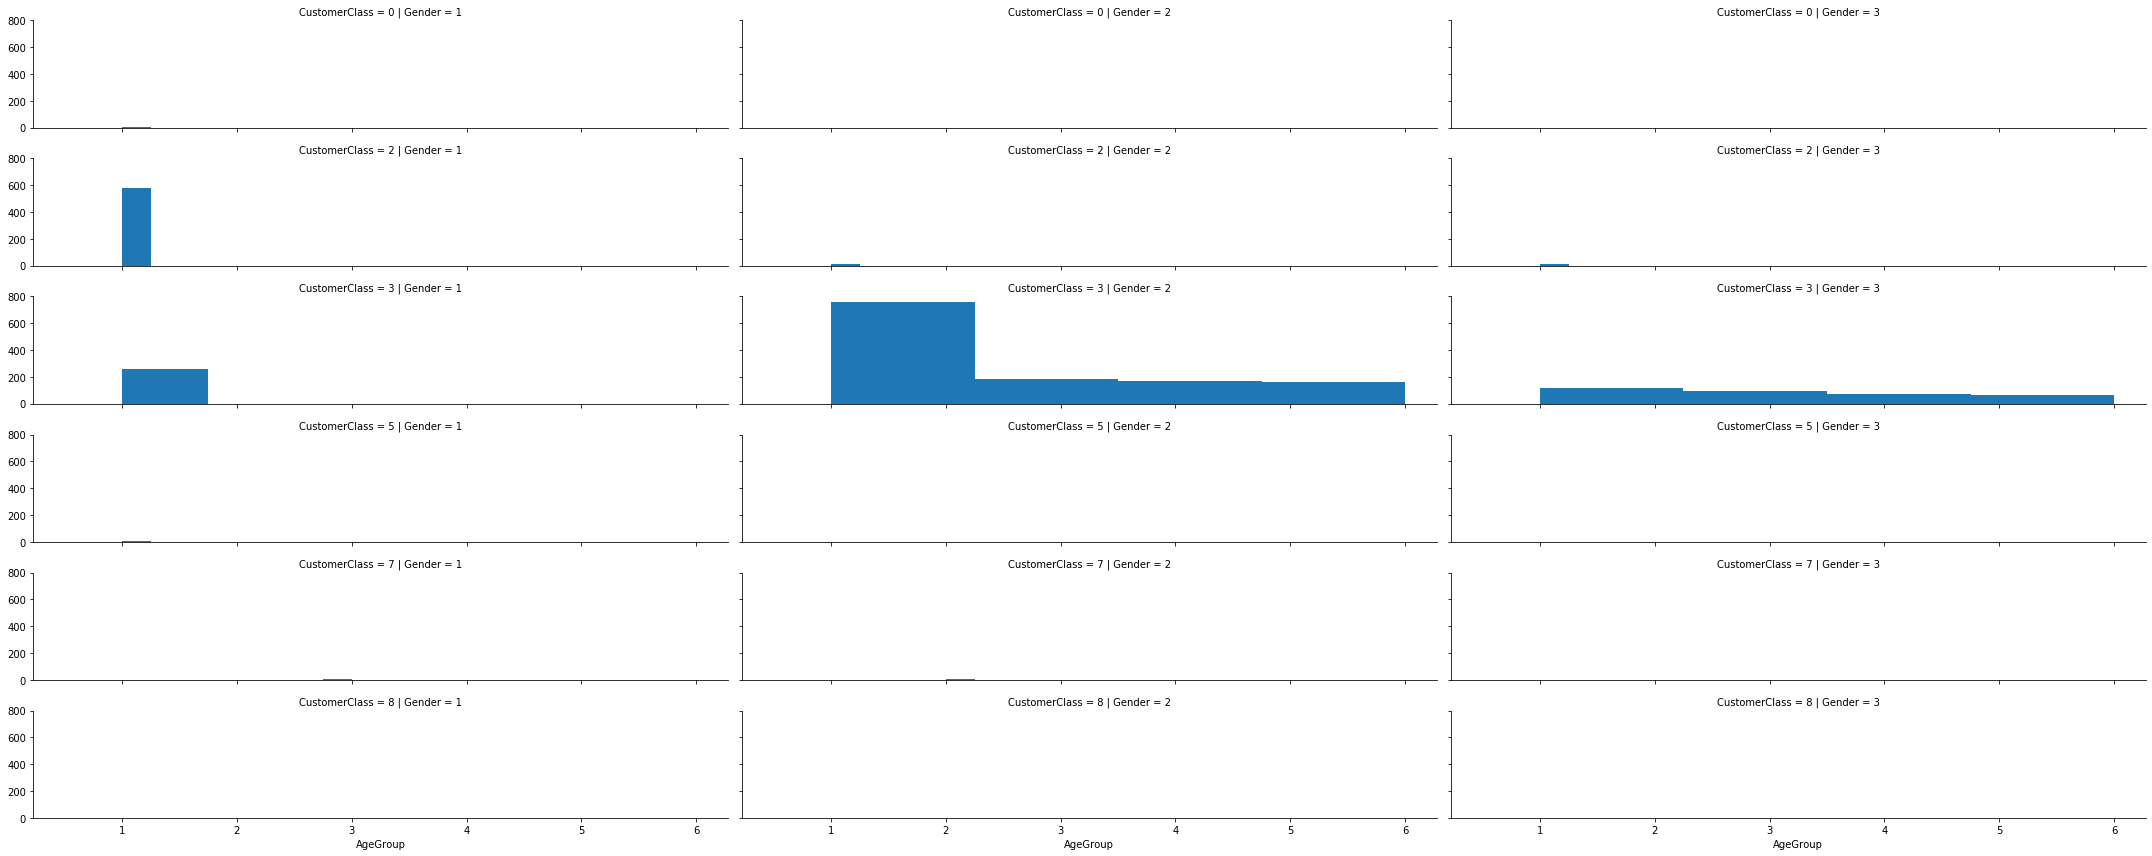

In [24]:
# AgeGroup:   [[0,25) < [25,35) < [35,45) < [45, 55) < [55,65) < [65,100] ]
g=sns.FacetGrid(df_customer,col='Gender',row='CustomerClass',aspect=5,height=2)
g.map(plt.hist,'AgeGroup',bins=4)

In [405]:
## CustomerClass's corresponding most popular nationality: 
# Nationality: 'GB': 25, 'US':70,'DE': 18
pd.crosstab(df_customer.NationalityCode,df_customer.CustomerClass).sort_values(by=3,ascending=False).head()

CustomerClass,0,1,2,3,5
NationalityCode,,,,,
18,0,3,0,393,0
25,0,2,492,364,0
70,0,0,92,332,0
63,0,0,0,72,0
17,0,0,0,67,0


- CustomerClass 2: dominant AgeGroup is 1(less than 25 yrs), Gender is 0 ( unknown gender class), most dominant nationality is GB. Its most popualr Rate is Early - 60 days, followed by Fully Flexible
- CustomerClass 3: dominant AgeGroup is 25-35 yrs with Gender of 1,mixed with decent amount of AgeGroup less than 25ys with Gender of 0 and AgeGoup from 35-100 with Gender of 1 as well as much less amount of Gender of 2 with AgeGroup from 35-100.Its most dominant nationality is DE, followed closely by GB and US. Its most popular Rate is Fully Flexible, followed by Early - 60 & 21 days, Non Refundable BAR BB

### KMeans Clustering

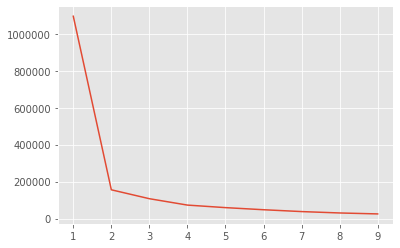

In [420]:
## Use KMeans to cluster customer base
## According to KMeans elbow curve, optimal k value is [2,5], so we choose 4
erros=[]
for i in range(1,10):
    km=KMeans(n_clusters=i)
    km.fit(train)
    erros.append(km.inertia_)
plt.plot(range(1,10),erros)

In [438]:
km=KMeans(n_clusters=4)
km.fit(train)
y_pred=km.predict(train)
prediction=pd.DataFrame({'prediction':y_pred})
labels=km.labels_
df_customer.insert(df_customer.shape[1],'KMeans',prediction)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0, 0.5, 'NationalityCode')

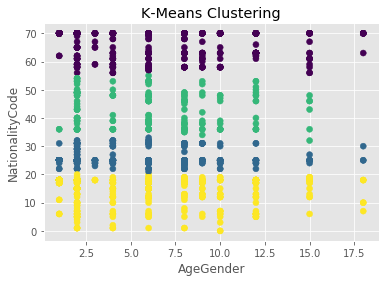

In [450]:
ax=plt.figure().add_subplot(111)
ax.scatter(df_customer['AgeGender'],df_customer['NationalityCode'],c=labels)
ax.set_title('K-Means Clustering')
ax.set_xlabel('AgeGender')
ax.set_ylabel('NationalityCode')

In [463]:
pd.crosstab(df_customer.RateName,df_customer.KMeans)

KMeans,0,1,2,3
RateName,,,,
Direct Booking,22,9,4,8
Early - 21 days,65,127,26,97
Early - 60 days,84,384,12,96
Fully Flexible,298,389,105,359
Min 3 nights,24,25,15,21
Min 4 nights,42,18,6,8
Min 5 nights,7,1,0,1
Non Refundable BAR BB,85,38,21,73
Suite Offer,12,10,0,9


- According to KMeans, customers can be clustered into 4 mains groups based on NationalityCode: KMeans0: 55-70 NationalityCode(such as US,alphabet P-U), KMeans1:35-55(such as JP, IT,alphabet J-N),KMeans2:20-35(such as GB,ES,FR,IE,alphabet E-I),KMeans3:0-20( such as AU,CH,DE,alphabet A-D). Their respective popular RateName are:{KMeans0:Fully Flexible, KMeans1:Fully Flexible&Early - 60 days, KMeans2:Fully Flexible, KMeans3:Fully Flexible)

### Based on Current Guest Data Distribution

In [75]:
rate=df_customer.groupby('RateName').median()[['AgeGroup','Gender','NationalityCode']]
rate=pd.DataFrame({'RateName':rate.index,'AgeGroup':rate.AgeGroup.values,'Gender':rate.Gender.values,'Nationality':rate.NationalityCode.values})

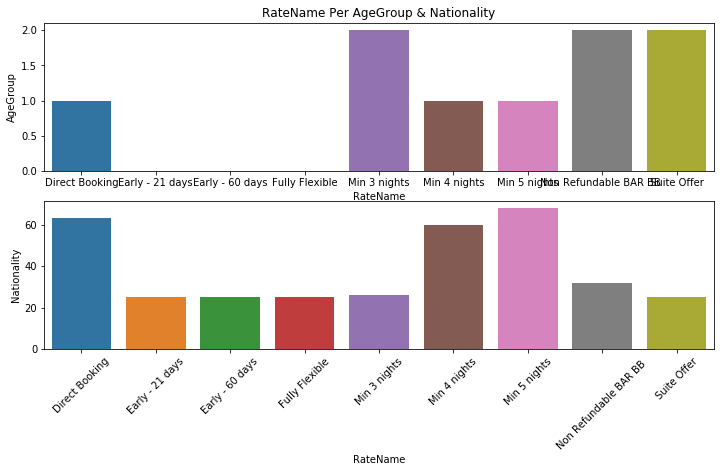

In [71]:
f,ax=plt.subplots(2,1,figsize=(12,6))
sns.barplot(rate.RateName,rate.AgeGroup,ax=ax[0]).set(title='RateName Per AgeGroup & Nationality')
plt.xticks(rotation=45)
sns.barplot(rate.RateName,rate.Nationality,ax=ax[1])

In [72]:
rate

,RateName,AgeGroup,Gender,Nationality
0,Direct Booking,1,1,63
1,Early - 21 days,0,1,25
2,Early - 60 days,0,0,25
3,Fully Flexible,0,1,25
4,Min 3 nights,2,1,26
5,Min 4 nights,1,1,60
6,Min 5 nights,1,1,68
7,Non Refundable BAR BB,2,1,32
8,Suite Offer,2,1,25


- Based on customer data distribution, for each RateName, they have their own main guest profiles.For AgeGroup=25 &Gender=1 & Nation=(SK,SC,TW), popualr rate are Direct Booking & Min 4 nights & Min 5 nights,for AgeGroup=0 & Nation=GB,  thier primary Rate are Early - 21/60 days & Fully Flexible, for AgeGroup=35 & Nation=(GR,IN,GB) their Rate are Min 3 nights & Non Refundable BAR BB & Suite Offer. For Gender=0, the only popular Rate is Early - 60 days

### Solution:


- Based on AgeGroup & Gender combination:
 - Customers could be split into two main groups and their corresponding Rate are: 
   - AgeGroup <25 & Gender =0 & Nationality=GB, Rate: Early - 60 days, followed by Fully Flexible
   - (AgeGroup 25-35 & Gender=1, AgeGroup<25 & Gender=0, AgeGroup 35-100 & Gender=1/2)& Nationality=(DE,US,GB),Rate:Fully Flexible, followed by Early - 60 & 21 days, Non Refundable BAR BB

- Based on NationalityCode:
 - NationalityCode(such as US,alphabet P-U), Rate:Fully Flexible
 - NationalityCode(such as JP, IT,alphabet J-N), Rate: Fully Flexible & Early - 60 days
 - NationalityCode(such as GB,ES,FR,IE,alphabet E-I), Rate: Fully Flexible
 - NationalityCode( such as AU,CH,DE,alphabet A-D), Rate: Fully Flexible

- Based on customer data distribution
 - AgeGroup=25 &Gender=1 & Nation=(SK,SC,TW), Rate: Direct Booking & Min 4 nights & Min 5 nights
 - AgeGroup=0 & Nation=GB, Rate: Early - 21/60 days & Fully Flexible  
 - AgeGroup=35 & Nation=(GR,IN,GB), Rate: Min 3 nights & Non Refundable BAR BB & Suite Offer
 - Gender=0, the only popular Rate is Early - 60 days

## What are the typical guests who pursue online check-in? Does it vary across week days?

In [ ]:
## Label encode TravelAgency
df_new.TravelAgency.replace({'Booking.com':1,'Expedia GB':2,'Destination of the world':3,'0':0,
 'Kuoni Destination Management':4,'Unknown':0,'TURISTICO s.r.o.':5  },inplace=True)
df_new.loc[-df_new.TravelAgency.isin([0,1,2,3,4,5]),'TravelAgency']=6
## Create train and y 
train=df_new[['TravelAgency','NationalityCode','ShortRateName','NightCount', 'NightCost_Sum', 'OccupiedSpace_Sum', 'GuestCount_Sum',
       'LeadTime', 'StayLength', 'ReservationState', 'Origin',
       'CommanderOrigin', 'Gender', 'Classification',
       'AgeGroup', 'HasEmail', 'BusinessSegment', 'EndWCode', 'StartWCode']]
y=df_new.IsOnlineCheckin.values
X_train,X_test,y_train,y_test=train_test_split(train,y,test_size=0.3,random_state=0)
acc_score=make_scorer(accuracy_score)
## XGBoost and tune its hyperparameters
xgb=XGBClassifier()
params={'learning_rate':[0.1,0.9],
'max_depth':[3,5],
'n_estimators':[100,500]}
clf=GridSearchCV(xgb,params,scoring=acc_score)

### Turn If OnlineCheck-in Into Binary Classification Problem Using XGBoost

In [64]:
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.9], 'max_depth': [3, 5],
                         'n_estimators': [100, 500]},
             pre_dispatch='2*n_jo

In [69]:
features=pd.Series(clf.best_estimator_.feature_importances_,train.columns)
img=features.sort_values(ascending=False).head(10)

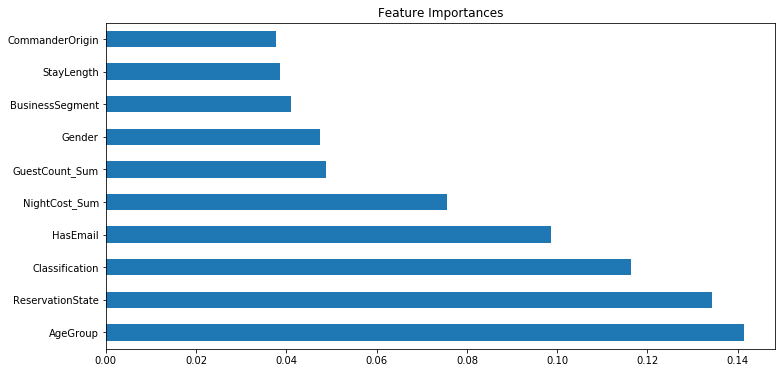

In [106]:
f,ax=plt.subplots(figsize=(12,6))
img.plot(kind='barh',title='Feature Importances')

- According to XGBoost, the most correlated features to IsOnlineCheckin are AgeGroup, ReservationState, Classification and HasEmail. 
- When CheckinOnline, guests' dominant characteristics are: ReservationState=3 & Classification=0 & HasEmail=1 & AgeGroup=35 & Gender=1 & NightCost_Sum > 544.629

In [24]:
## Guest's dominant ReservationState=3 & Origin=1 & Gender=1 & HasEmail=1 & AgeGroup=35 when CheckinOnline
pd.crosstab(df_new.ReservationState,df_new.IsOnlineCheckin)

IsOnlineCheckin,0,1
ReservationState,,
1,796,36
2,12,4
3,758,104
4,691,4
5,96,0


In [99]:
pd.crosstab(df_new.NightCost_Sum,df_new.IsOnlineCheckin)

IsOnlineCheckin,0,1
NightCost_Sum,,
0.0,815,20
1.0,773,59
2.0,765,69


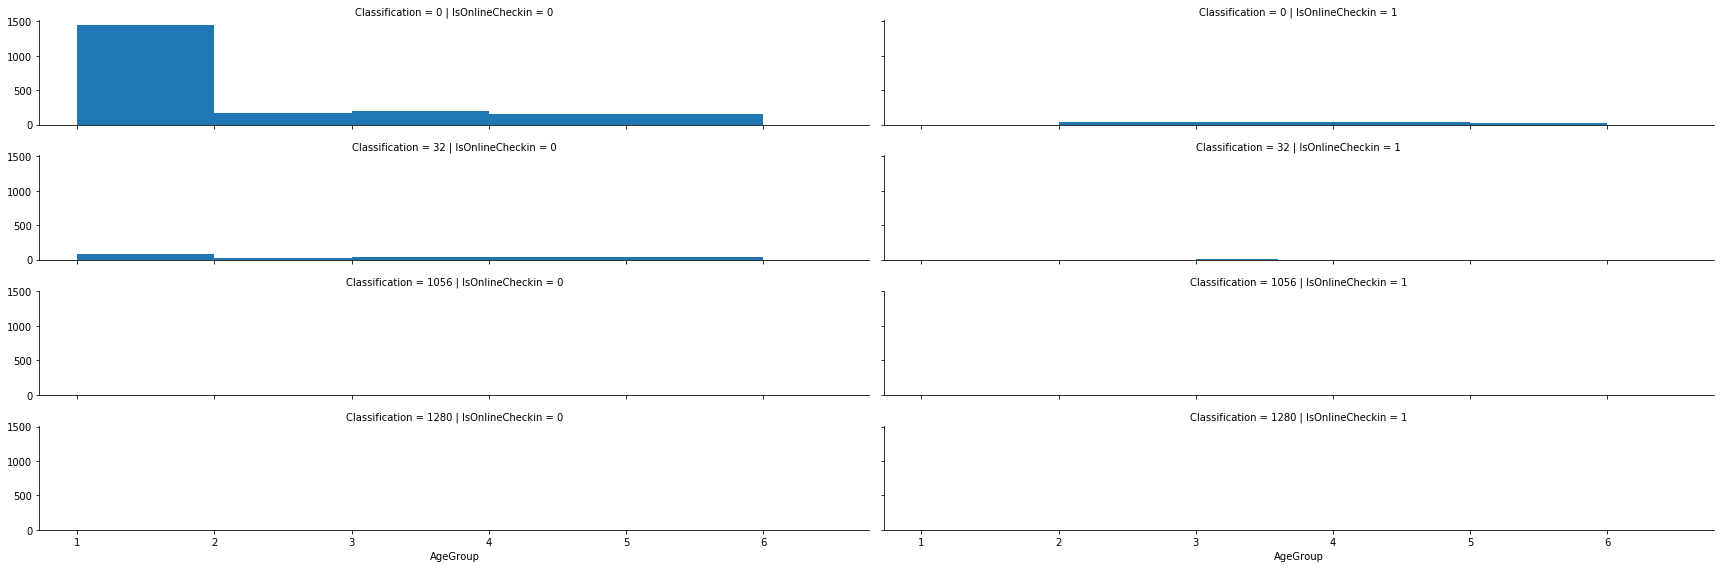

In [212]:
g=sns.FacetGrid(df_new,col='IsOnlineCheckin',row='Classification',aspect=6,height=2)
g.map(plt.hist,'AgeGroup',bins=5)

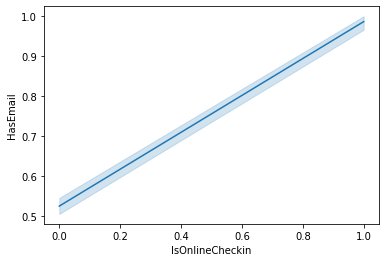

In [42]:
## When guest has emails they are more likely to checkin online
sns.lineplot(df.IsOnlineCheckin,df.HasEmail)

### Does it vary across week days?

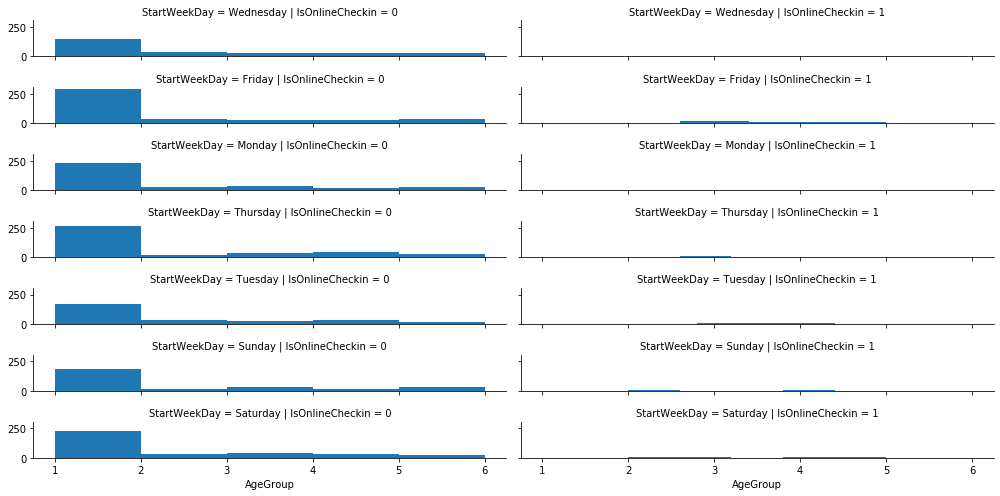

In [208]:
g=sns.FacetGrid(df_new,col='IsOnlineCheckin',row='StartWeekDay',aspect=7,height=1)
g.map(plt.hist,'AgeGroup',bins=5)

- AgeGroup for IsCheckinOnline varies across weekday. Friday is the most popualr day for AgeGroup 30-40, Monday solely 55-65,Saturday no/very few checkin for AgeGroup 35-45.

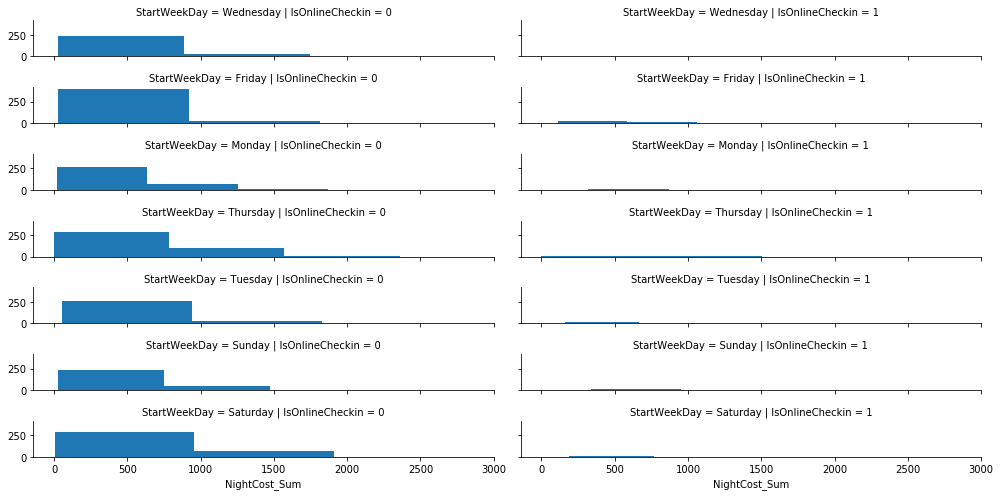

In [209]:
g=sns.FacetGrid(df_new,col='IsOnlineCheckin',row='StartWeekDay',aspect=7,height=1)
g.map(plt.hist,'NightCost_Sum',bins=3)

- NightCost_Sum varies across weekday: From Tuesday to Thursday, guests are building up spend patterns and reach the maximum on Fridays. Friday guests tend to spend the most(> 544.629), Wednesday & Tuesday spend the least.

### Solution:

- According to XGBoost, the most correlated features to IsOnlineCheckin are AgeGroup, ReservationState, Classification and HasEmail.When CheckinOnline, guests' dominant characteristics are: ReservationState=3 & Classification=0 & HasEmail=1 & AgeGroup=35 & Gender=1 & NightCost_Sum > 544.629
- AgeGroup for IsCheckinOnline varies across weekday. Friday is the most popualr day for AgeGroup 30-40, Monday solely 55-65,Saturday no/very few checkin for AgeGroup 35-45.
- NightCost_Sum varies across weekday: From Tuesday to Thursday, guests are building up spend patterns and reach the maximum on Fridays. Friday guests tend to spend the most(> 544.629), Wednesday & Tuesday spend the least.

## Look at the night cost per occupied space. What guest segment is the most profitable per occupied space unit? And what guest segment is the least profitable?

In [6]:
## We have OccupiedSpace_Sum=0, in order to calculate CostPerSpace, we scale it up by 1.
df_new['OccupiedSpace_Sum']=df_new.OccupiedSpace_Sum.apply(lambda x: x+1)
df_new['CostPerSpace']=(df_new.NightCost_Sum/df_new.OccupiedSpace_Sum).round()
cost_band=pd.qcut(df_new.CostPerSpace,4)
# CostPerSpace: [(-0.001, 52.0] < (52.0, 81.0] < (81.0, 197.0] < (197.0, 2711.0]]
df_new.loc[(df_new.CostPerSpace>-0.001)&(df_new.CostPerSpace<=52),'CostPerSpace']=0
df_new.loc[(df_new.CostPerSpace>52)&(df_new.CostPerSpace<=81),'CostPerSpace']=1
df_new.loc[(df_new.CostPerSpace>81)&(df_new.CostPerSpace<=197),'CostPerSpace']=2
df_new.loc[(df_new.CostPerSpace>197)&(df_new.CostPerSpace<=2771),'CostPerSpace']=3
## Aggregate the data based on each CostPerSpace
df_cost_space=df_new.groupby('CostPerSpace').agg({'AgeGroup':'median','NationalityCode':'median','GuestCount_Sum':'median','StayLength':'median',
'ReservationState':'median','Gender':'median','BusinessSegment':'median','StartWCode':'median','Origin':'median'})
df_cost_space.reset_index(inplace=True)

- In order to calculate CostPerSpace, we need to use NightCost_Sum over by OccupiedSpace_Sum. However, there are OccupiedSpace_Sum=0, so we scaled it up by 1. Based on computed CostPerSpace, we quartile cut it into bands and turn it to ordinal [(-0.001, 52.0] < (52.0, 81.0] < (81.0, 197.0] < (197.0, 2711.0]]. We aggregated the data based on each CostPerSpace group. 

In [187]:
df_cost_space

,CostPerSpace,AgeGroup,NationalityCode,GuestCount_Sum,StayLength,ReservationState,Gender,BusinessSegment,StartWCode,Origin
0,0.0,1,25,1,3,1,2,1,3,2
1,1.0,2,25,1,2,3,2,4,3,1
2,2.0,2,25,1,2,3,2,4,3,1
3,3.0,1,25,1,3,4,1,3,3,1


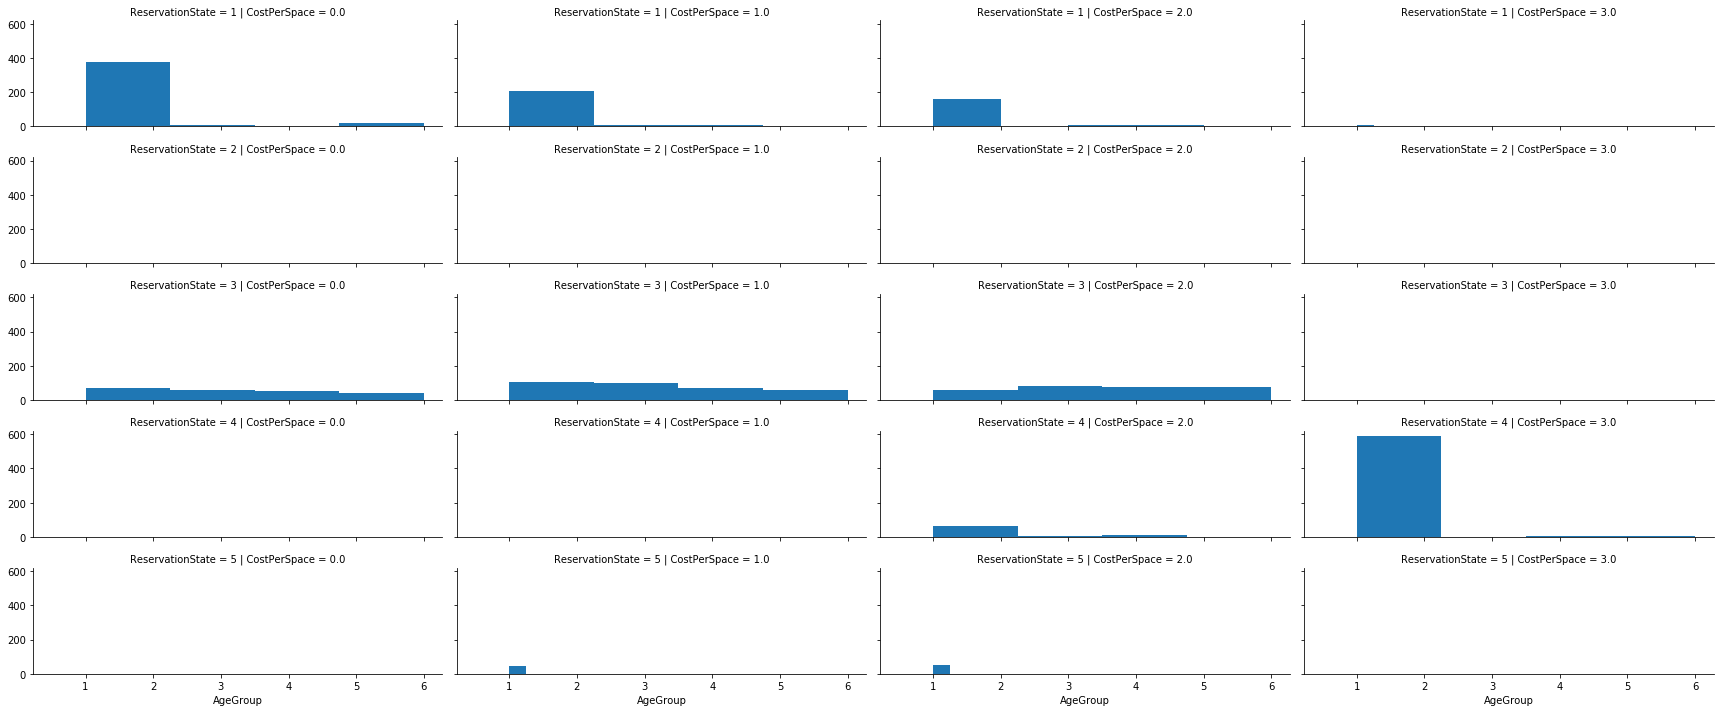

In [11]:
g=sns.FacetGrid(df_new,col='CostPerSpace',row='ReservationState',aspect=3,height=2)
g.map(plt.hist,'AgeGroup',bins=4)

[Text(0.5, 1.0, 'CostPerSpace Nationality')]

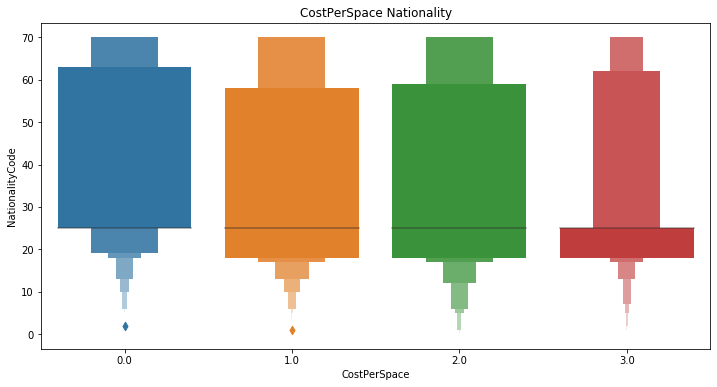

In [228]:
f,ax=plt.subplots(figsize=(12,6))
sns.boxenplot(df_new.CostPerSpace,df_new.NationalityCode).set(title='CostPerSpace Nationality')

- The most profitable customer segment is: ReservationState=4 & BusinessSegment ='Leisure' & Gender =0 & AgeGroup=25
- The least profitable customer segment is : ReservationState=1 & BusinessSegment='FIT' & Gender =1 & AgeGroup=25
- For both groups, the dominant NationalityCode is GB

### Solution

- Based on data distribution:
 - The most profitable customer segment is: ReservationState=4 & BusinessSegment ='Leisure' & Gender =0 & AgeGroup=25
 - The least profitable customer segment is : ReservationState=1 & BusinessSegment='FIT' & Gender =1 & AgeGroup=25
 - For both groups, the dominant NationalityCode is GB

# Thank you